# M4 - Brief 1 - Benchmark de modèles d'IA pour une tâche de régression

In [23]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import median_abs_deviation
import missingno as msno
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Librairies pour le machine learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import xgboost as xgb

# Métriques d'évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuration des styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

Dimensions du dataset : (506, 14)

Premières lignes :


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2



Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB
None

Statistiques descriptives :


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


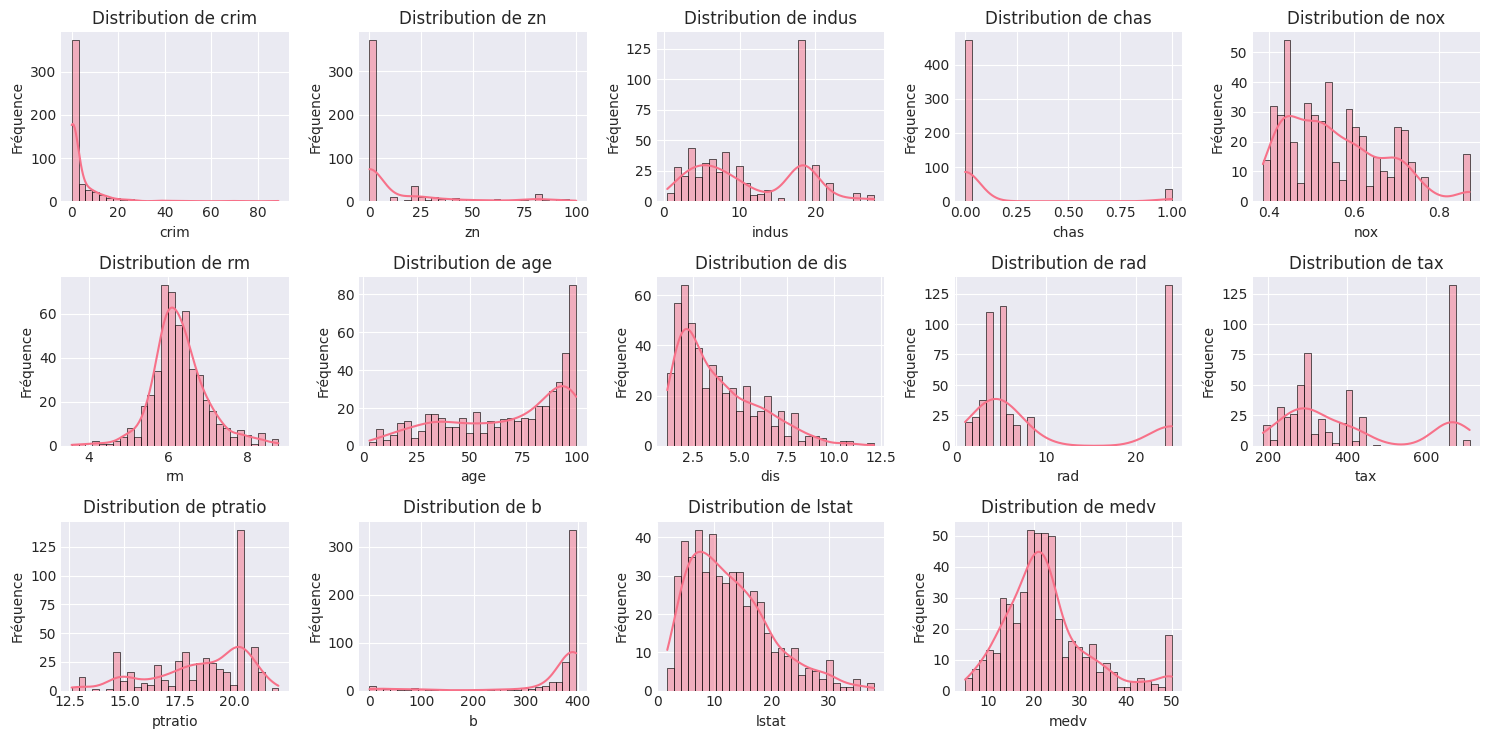

In [2]:
# Chargement des données
df = pd.read_csv('data/bostonhousing.csv')

# Affichage des premières lignes
print("Dimensions du dataset :", df.shape)
print("\nPremières lignes :")
display(df.head())

print("\nInformations sur le dataset :")
print(df.info())

print("\nStatistiques descriptives :")
display(df.describe())

# Affichage de la distribution des données (les données sont toutes numériques)
plt.figure(figsize=(15, 12))

for i, col in enumerate(df.columns, 1):
    plt.subplot(5, 5, i)     # 3x3 pour 9 colonnes
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

In [3]:
# Analyse des valeurs manquantes
print("VALEURS MANQUANTES")
print("="*40)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Valeurs manquantes': missing_values,
    'Pourcentage (%)': missing_percent
})
display(missing_df[missing_df['Valeurs manquantes'] > 0])

# Analyse des doublons
duplicates = df.duplicated().sum()
print(f"\nNombre de doublons : {duplicates}")

VALEURS MANQUANTES


,Valeurs manquantes,Pourcentage (%)



Nombre de doublons : 0


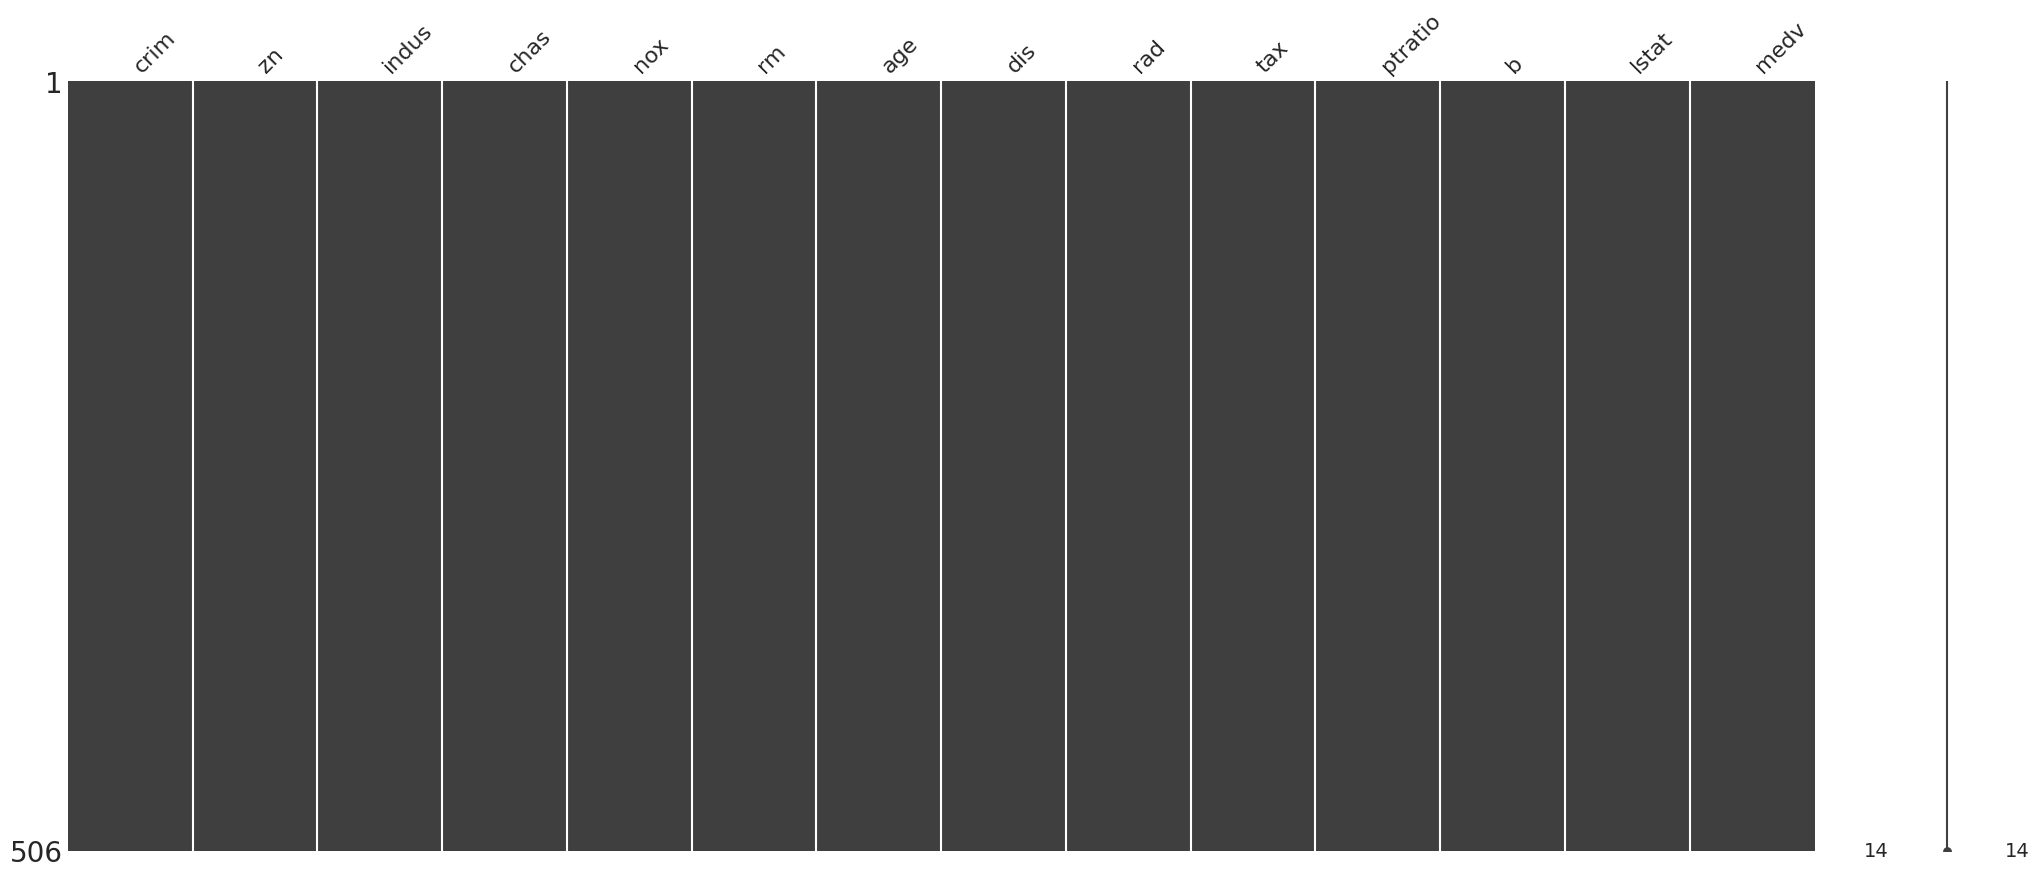

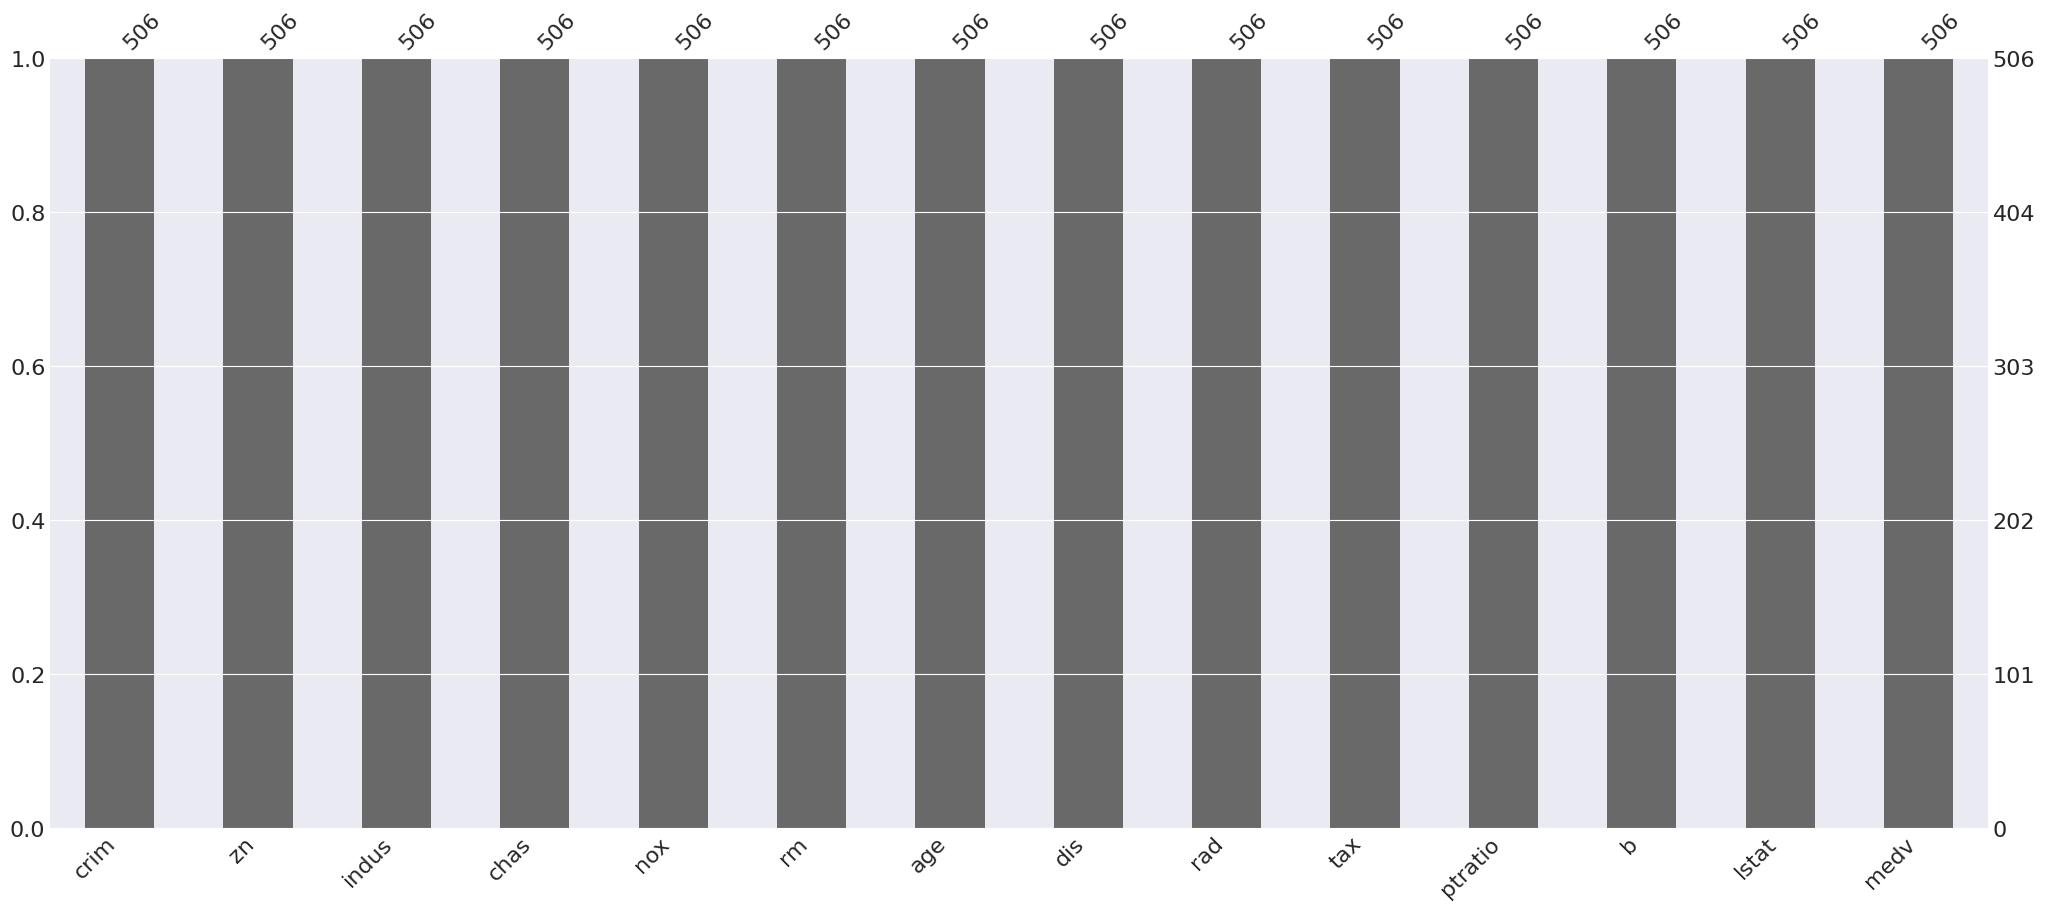

Nb lignes manquantes : 0 / 506


In [4]:
# Visualiser la matrice des valeurs manquantes
msno.matrix(df)
plt.show()

# Visualiser le barplot des colonnes manquantes
msno.bar(df)
plt.show()

# Nombre de lignes avec au moins une valeur manquante
missing_line = df.isna().any(axis=1).sum()
total_line = df.shape[0]
print(f"Nb lignes manquantes : {missing_line} / {total_line}")

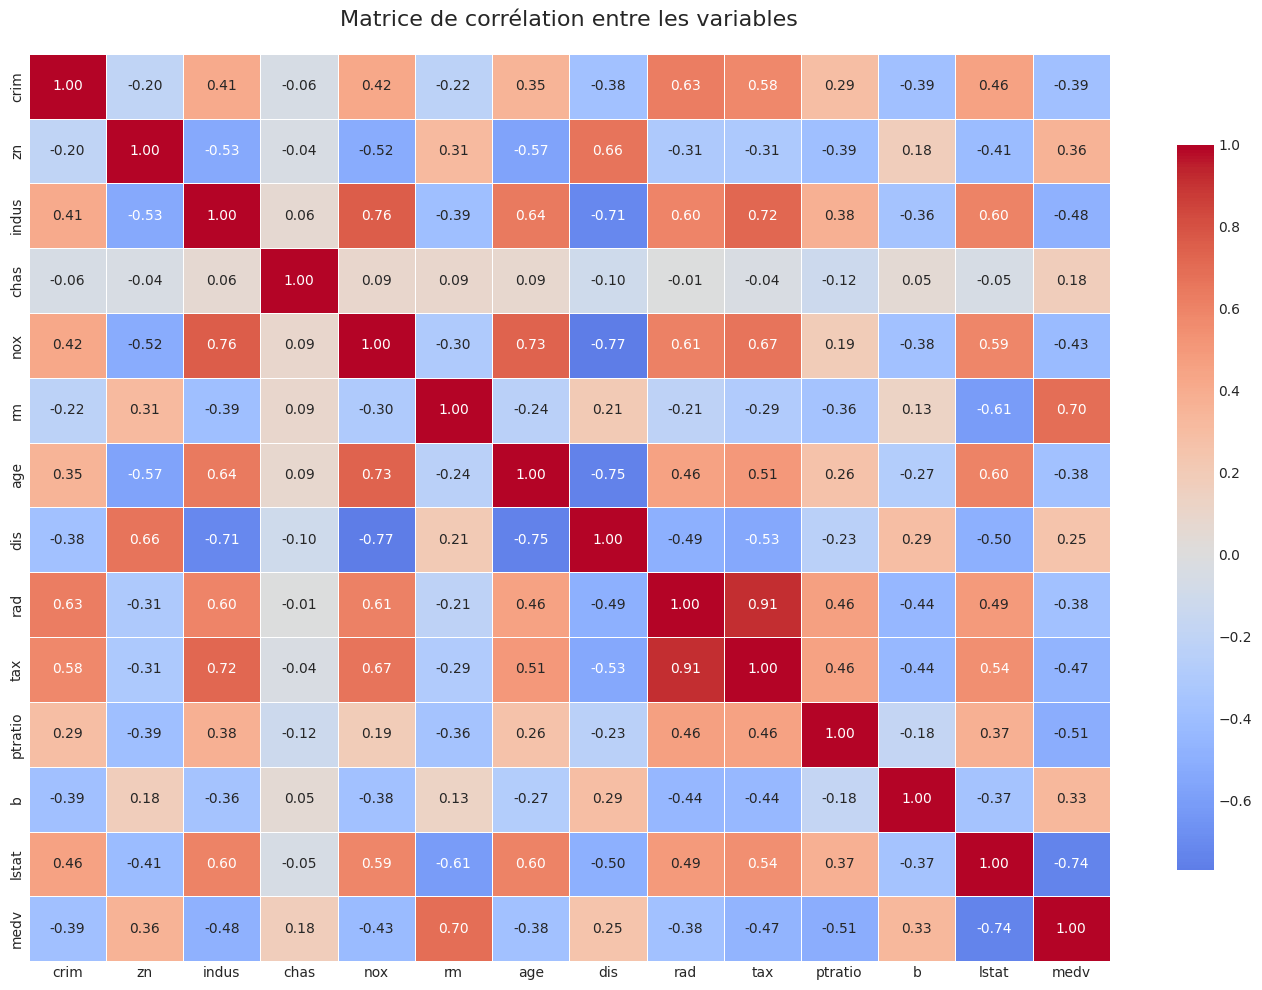

In [5]:
# Matrice de corrélation
correlation_matrix = df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation entre les variables', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## Nettoyage des Données

### Identifier les colonnes utiles au résultat




### Supprimer les colonnes non pertinentes

Au vu de la matrice de confusion et étant donné que les données sont complètes, je garde toutes les colonnes. Sauf la colonne nommée **B** pour des raisons éthiques. La variable **B** est définie dans le dataset comme ```B = 1000 * (Bk - 0.63)²``` où **Bk représente la proportion de population noire** dans le quartier. Cette variable risque fortement de créer un biais éthique, de plus elle a été créée dans un contexte historique particulier (années 1970), son utilisation actuelle pour la prédiction immobilière pourrait dépasser sa finalité initiale.

### Traitement des outliers
La Méthode IQR n'est pas applicable, car les distributions ne sont pas symétriques dans la majorité des cas.
Je mets donc au point la stratégie suivante de traitement des outliers:

In [6]:
# Stratégie différenciée selon la variable
outlier_strategy = {
    'crim': {
        'method': 'percentile',
        'params': {'upper_percentile': 99, 'lower_percentile': 0},
        'reason': 'Distribution exponentielle, limite inférieure à 0'
    },
    'zn': {
        'method': 'percentile', 
        'params': {'upper_percentile': 95},
        'reason': 'Beaucoup de zéros, distribution asymétrique'
    },
    'rm': {
        'method': 'iqr_adjusted',
        'params': {},
        'reason': 'Distribution relativement normale'
    },
    'age': {
        'method': 'percentile',
        'params': {'upper_percentile': 99},
        'reason': 'Distribution uniforme avec quelques valeurs extrêmes'
    },
    'dis': {
        'method': 'mad',
        'params': {'threshold': 3.0},
        'reason': 'Asymétrie modérée'
    },
    'rad': {
        'method': 'none', # Variable catégorielle, pas d'outliers
        'params': {'threshold': 2.0},
        'reason': 'RAD est une variable catégorielle ordinale'
    },
    'chas': {
        'method': 'none',  # Variable binaire, pas d'outliers
        'params': {},
        'max_acceptable': 0,
        'reason': 'Variable catégorielle binaire'
    },
    'lstat': {
        'method': 'iqr_adjusted',
        'params': {},
        'reason': 'Distribution modérément asymétrique'
    },
    'medv': {
        'method': 'percentile',
        'params': {'lower_percentile': 0.5, 'upper_percentile': 99.5},
        'reason': 'Variable cible, traitement conservateur'
    },
    'ptratio': {
        'method': 'iqr_standard',
        'params': {},
        'reason': 'Distribution relativement symétrique'
    },
    'tax': {
        'method': 'percentile',
        'params': {'upper_percentile': 99},
        'reason': 'Quelques valeurs extrêmes très élevées'
    }
}

In [17]:
### 4.1 Détection et traitement des outliers
print("DÉTECTION DES OUTLIERS")
print("="*40)

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    return outliers_mask, lower_bound, upper_bound

# Problème : Pour CRIM, lower_bound sera négatif (impossible)

def detect_outliers_iqr_adjusted(data, column):
    """
    IQR avec limites différentes selon le sens de l'asymétrie
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    median = data[column].median()
    IQR = Q3 - Q1
    
    skew = data[column].skew()
    
    # Ajustement des coefficients selon l'asymétrie
    if skew > 1:  # Forte asymétrie positive
        lower_coef = 1.5
        upper_coef = 3.0  # Plus tolérant vers le haut
    elif skew < -1:  # Forte asymétrie négative
        lower_coef = 3.0
        upper_coef = 1.5
    else:  # Distribution relativement symétrique
        lower_coef = 1.5
        upper_coef = 1.5
    
    lower_bound = Q1 - lower_coef * IQR
    upper_bound = Q3 + upper_coef * IQR
    
    # Ajustement pour les variables avec limite naturelle (ex: CRIM ≥ 0)
    if column in ['crim', 'zn', 'indus', 'nox', 'age', 'tax', 'ptratio', 'lstat']:
        lower_bound = max(lower_bound, 0)
    
    outliers_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    return outliers_mask, lower_bound, upper_bound

def detect_outliers_mad(data, column, threshold=3.5):
    """
    Méthode Median Absolute Deviation - plus robuste aux outliers
    """
    median = np.median(data[column])
    mad = median_abs_deviation(data[column], scale='normal')
    
    if mad == 0:  # Éviter la division par zéro
        mad = np.std(data[column])
    
    # Z-score robuste
    modified_z_scores = 0.6745 * (data[column] - median) / mad
    
    outliers_mask = np.abs(modified_z_scores) > threshold
    return outliers_mask

def detect_outliers_percentile(data, column, lower_percentile=1, upper_percentile=99):
    """
    Méthode simple basée sur les percentiles
    """
    lower_bound = np.percentile(data[column], lower_percentile)
    upper_bound = np.percentile(data[column], upper_percentile)
    
    outliers_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    return outliers_mask, lower_bound, upper_bound

def detect_outliers_hybrid(data, variable_strategy=outlier_strategy):
    """
    Détection adaptative des outliers selon le type de variable
    """
    outliers_summary = {}
    outlier_mask = pd.Series(False, index=data.index)
    
    for var in data.select_dtypes(include=[np.number]).columns:
        if var not in variable_strategy:
            # Méthode par défaut : MAD
            outliers = detect_outliers_mad(data, var)
            method = 'mad (default)'
        else:
            strategy = variable_strategy[var]
            method = strategy['method']
            
            if method == 'iqr_standard':
                outliers, _, _ = detect_outliers_iqr(data, var)
            elif method == 'iqr_adjusted':
                outliers, _, _ = detect_outliers_iqr_adjusted(data, var)
            elif method == 'mad':
                outliers = detect_outliers_mad(data, var, **strategy.get('params', {}))
            elif method == 'percentile':
                outliers, _, _ = detect_outliers_percentile(data, var, **strategy.get('params', {}))
            else:
                outliers = pd.Series(False, index=data.index)
        
        outliers_summary[var] = {
            'count': outliers.sum(),
            'percentage': outliers.sum() / len(data) * 100,
            'method': method
        }
        
        outlier_mask = outlier_mask | outliers
    
    return outlier_mask, outliers_summary

# Application
outlier_mask, summary = detect_outliers_hybrid(df)

print("Résumé de la détection d'outliers :")
print("="*60)
for var, info in summary.items():
    print(f"{var:10} : {info['count']:3d} outliers ({info['percentage']:5.1f}%) - {info['method']}")

# Créer le dictionnaire results
results = {}
for var, info in summary.items():
    results[var] = {
        'count': info['count'],
        'percentage': round(info['percentage'], 1),  # Arrondir à 1 décimale
        'method': info['method']
    }

print("\n" + "="*60)
print("DICTIONNAIRE results généré :")
print("="*60)
print("results = {")
for i, (var, info) in enumerate(results.items()):
    comma = "," if i < len(results) - 1 else ""
    print(f"    '{var}': {{'count': {info['count']}, 'percentage': {info['percentage']}, 'method': '{info['method']}'}}{comma}")
print("}")

DÉTECTION DES OUTLIERS
Résumé de la détection d'outliers :
crim       :   6 outliers (  1.2%) - percentile
zn         :  14 outliers (  2.8%) - percentile
indus      :   0 outliers (  0.0%) - mad (default)
chas       :   0 outliers (  0.0%) - none
nox        :   0 outliers (  0.0%) - mad (default)
rm         :  30 outliers (  5.9%) - iqr_adjusted
age        :   6 outliers (  1.2%) - percentile
dis        :   1 outliers (  0.2%) - mad
rad        :   0 outliers (  0.0%) - none
tax        :   6 outliers (  1.2%) - percentile
ptratio    :  15 outliers (  3.0%) - iqr_standard
b          :  81 outliers ( 16.0%) - mad (default)
lstat      :   7 outliers (  1.4%) - iqr_adjusted
medv       :   3 outliers (  0.6%) - percentile

DICTIONNAIRE results généré :
results = {
    'crim': {'count': 6, 'percentage': 1.2, 'method': 'percentile'},
    'zn': {'count': 14, 'percentage': 2.8, 'method': 'percentile'},
    'indus': {'count': 0, 'percentage': 0.0, 'method': 'mad (default)'},
    'chas': {'count'

In [18]:
# A. Variables par type
categorical_vars = [v for v, s in summary.items() if s['method'] == 'none']
continuous_vars = [v for v, s in summary.items() if s['method'] != 'none']
continuous_with_outliers = [v for v in continuous_vars if summary[v]['count'] > 0]

print(f"\nA. CATÉGORISATION :")
print(f"   • Variables catégorielles : {len(categorical_vars)}")
print(f"   • Variables continues : {len(continuous_vars)}")
print(f"   • Variables continues avec outliers : {len(continuous_with_outliers)}")

print(f"\nB. VARIABLES CATÉGORIELLES :")
for var in categorical_vars:
    print(f"   • {var}")

print(f"\nC. VARIABLES CONTINUES AVEC OUTLIERS :")
for var in sorted(continuous_with_outliers, 
                  key=lambda x: summary[x]['percentage'], 
                  reverse=True):
    info = summary[var]
    print(f"   • {var:8} : {info['count']:3d} outliers ({info['percentage']:5.1f}%) - {info['method']}")


A. CATÉGORISATION :
   • Variables catégorielles : 2
   • Variables continues : 12
   • Variables continues avec outliers : 10

B. VARIABLES CATÉGORIELLES :
   • chas
   • rad

C. VARIABLES CONTINUES AVEC OUTLIERS :
   • b        :  81 outliers ( 16.0%) - mad (default)
   • rm       :  30 outliers (  5.9%) - iqr_adjusted
   • ptratio  :  15 outliers (  3.0%) - iqr_standard
   • zn       :  14 outliers (  2.8%) - percentile
   • lstat    :   7 outliers (  1.4%) - iqr_adjusted
   • crim     :   6 outliers (  1.2%) - percentile
   • age      :   6 outliers (  1.2%) - percentile
   • tax      :   6 outliers (  1.2%) - percentile
   • medv     :   3 outliers (  0.6%) - percentile
   • dis      :   1 outliers (  0.2%) - mad


In [19]:
# %% [markdown]
# ### 4.3.1 Traitement des outliers - Approche finale

# %%
print("🎯 STRATÉGIE DE TRAITEMENT FINALE")
print("="*60)

# Copie pour traitement (on supprime la colonne B)
df_final = df.copy().drop(columns=['b'])
treatments = []

print("\nA. VARIABLES CATÉGORIELLES (pas de traitement) :")
for var in categorical_vars:
    treatments.append((var, 'Aucun traitement', 'Variable catégorielle'))
    print(f"   • {var} : conservation complète")

print("\nB. VARIABLES CONTINUES SANS OUTLIERS (pas de traitement) :")
no_outlier_vars = [var for var in continuous_vars if results[var]['count'] == 0]
for var in no_outlier_vars:
    treatments.append((var, 'Aucun traitement', '0 outlier détecté'))
    print(f"   • {var} : conservation complète")

print("\nC. VARIABLES À TRAITER :")

# 1. B - Traitement spécial (problèmes éthiques + 16% outliers)
if 'b' in df_final.columns:
    # OPTION 1 : Suppression (recommandée éthiquement)
    # df_final = df_final.drop(columns=['b'])
    # treatments.append(('b', 'Supprimée', 'Problèmes éthiques/RGPD'))
    
    # OPTION 2 : Capping strict (si conservation nécessaire)
    lower = np.percentile(df['b'], 1)
    upper = np.percentile(df['b'], 99)
    outliers_before = (df['b'] < lower).sum() + (df['b'] > upper).sum()
    df_final['b'] = np.clip(df['b'], lower, upper)
    outliers_after = (df_final['b'] < lower).sum() + (df_final['b'] > upper).sum()
    treatments.append(('b', f'Capping [{lower:.1f}, {upper:.1f}]', 
                      f'{outliers_before}→{outliers_after} outliers'))
    print(f"   ✅ b : Capping strict (1-99%)")

# 2. RM - Capping léger (5.9% outliers)
if 'rm' in df_final.columns:
    lower = np.percentile(df['rm'], 1)
    upper = np.percentile(df['rm'], 99)
    outliers_before = (df['rm'] < lower).sum() + (df['rm'] > upper).sum()
    df_final['rm'] = np.clip(df['rm'], lower, upper)
    outliers_after = (df_final['rm'] < lower).sum() + (df_final['rm'] > upper).sum()
    treatments.append(('rm', f'Capping [{lower:.1f}, {upper:.1f}]',
                      f'{outliers_before}→{outliers_after} outliers'))
    print(f"   ✅ rm : Capping léger (1-99%)")

# 3. MEDV - Capping très conservateur (variable cible)
if 'medv' in df_final.columns:
    lower = np.percentile(df['medv'], 0.5)
    upper = np.percentile(df['medv'], 99.5)
    outliers_before = (df['medv'] < lower).sum() + (df['medv'] > upper).sum()
    df_final['medv'] = np.clip(df['medv'], lower, upper)
    outliers_after = (df_final['medv'] < lower).sum() + (df_final['medv'] > upper).sum()
    treatments.append(('medv', f'Capping [{lower:.1f}, {upper:.1f}]',
                      f'{outliers_before}→{outliers_after} outliers'))
    print(f"   ✅ medv : Capping très conservateur (0.5-99.5%)")

# 4. Autres variables avec outliers
other_vars = [v for v in continuous_with_outliers 
              if v not in ['b', 'rm', 'medv'] and v in df_final.columns]

for var in other_vars:
    if results[var]['percentage'] > 2:  # Seuil de 2%
        upper = np.percentile(df[var], 99)
        outliers_before = (df[var] > upper).sum()
        df_final[var] = np.minimum(df[var], upper)
        outliers_after = (df_final[var] > upper).sum()
        treatments.append((var, f'Capping ≤{upper:.1f}',
                          f'{outliers_before}→{outliers_after} outliers'))
        print(f"   ✅ {var} : Capping au 99ème percentile")

# %%
# RÉSUMÉ DU TRAITEMENT
print("\n" + "="*60)
print("RÉSUMÉ DU TRAITEMENT APPLIQUÉ")
print("="*60)

print(f"\n{'Variable':8} {'Action':25} {'Détail':30}")
print("-"*70)
for var, action, detail in treatments:
    print(f"{var:8} {action:25} {detail:30}")

print(f"\n📊 STATISTIQUES :")
print(f"• Variables totales : {len(df.columns)}")
print(f"• Variables traitées : {len([t for t in treatments if 'Capping' in t[1] or 'Supprimée' in t[1]])}")
print(f"• Variables inchangées : {len([t for t in treatments if 'Aucun' in t[1]])}")
print(f"• Dataset original : {df.shape}")
print(f"• Dataset final : {df_final.shape}")

🎯 STRATÉGIE DE TRAITEMENT FINALE

A. VARIABLES CATÉGORIELLES (pas de traitement) :
   • chas : conservation complète
   • rad : conservation complète

B. VARIABLES CONTINUES SANS OUTLIERS (pas de traitement) :
   • indus : conservation complète
   • nox : conservation complète

C. VARIABLES À TRAITER :
   ✅ rm : Capping léger (1-99%)
   ✅ medv : Capping très conservateur (0.5-99.5%)
   ✅ zn : Capping au 99ème percentile
   ✅ ptratio : Capping au 99ème percentile

RÉSUMÉ DU TRAITEMENT APPLIQUÉ

Variable Action                    Détail                        
----------------------------------------------------------------------
chas     Aucun traitement          Variable catégorielle         
rad      Aucun traitement          Variable catégorielle         
indus    Aucun traitement          0 outlier détecté             
nox      Aucun traitement          0 outlier détecté             
rm       Capping [4.5, 8.3]        12→0 outliers                 
medv     Capping [6.0, 50.0]      

In [ ]:
## BENCHMARK DES MODÈLES DE RÉGRESSION

In [25]:
print("PRÉPARATION POUR LA MODÉLISATION")
print("="*60)

# Supposons que df_final est votre dataset nettoyé
# Si vous avez supprimé b :
df_final = df.drop(columns=['b']).copy()

# 1. SÉPARATION X/y
X = df_final.drop(columns=['medv'])  # Features
y = df_final['medv']                 # Target

print("1. SÉPARATION DES FEATURES ET DE LA TARGET :")
print(f"   • Features (X) : {X.shape}")
print(f"   • Target (y)   : {y.shape}")
print(f"   • Variables : {list(X.columns)}")

# %%
# 2. ENCODAGE DES VARIABLES CATÉGORIELLES
print("\n2. ENCODAGE DES VARIABLES CATÉGORIELLES :")

# Identifier les variables catégorielles
categorical_features = ['chas', 'rad']  # Basé sur notre analyse
numerical_features = [col for col in X.columns if col not in categorical_features]

print(f"   • Catégorielles : {categorical_features}")
print(f"   • Numériques : {len(numerical_features)} variables")

# Encodage One-Hot pour chas et rad
from sklearn.preprocessing import OneHotEncoder

# Pour chas (déjà 0/1, mais on peut le garder tel quel ou one-hot)
# Pour rad (variable ordinale avec plusieurs valeurs)
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = encoder.fit_transform(X[categorical_features])

# Créer les noms des colonnes encodées
encoded_columns = []
for i, col in enumerate(categorical_features):
    categories = encoder.categories_[i]
    for cat in categories[1:]:  # drop='first' ignore la première catégorie
        encoded_columns.append(f"{col}_{int(cat)}")

# Créer un DataFrame avec les features encodées
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns, index=X.index)

# Combiner avec les features numériques
X_prepared = pd.concat([X[numerical_features], X_encoded_df], axis=1)

print(f"   • Après encodage : {X_prepared.shape}")
print(f"   • Nouvelles colonnes : {list(X_prepared.columns)}")

# %%
# 3. NORMALISATION DES DONNÉES
print("\n3. NORMALISATION DES DONNÉES :")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_prepared)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_prepared.columns, index=X_prepared.index)

print(f"   • Normalisation StandardScaler appliquée")
print(f"   • Moyenne après normalisation : {X_scaled_df.mean().mean():.2f}")
print(f"   • Écart-type après normalisation : {X_scaled_df.std().mean():.2f}")

# %%
# 4. SÉPARATION TRAIN/TEST
print("\n4. SÉPARATION TRAIN/TEST :")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"   • Train set : {X_train.shape}")
print(f"   • Test set  : {X_test.shape}")
print(f"   • Proportion : {len(X_train)/len(X_scaled_df)*100:.1f}% train, "
      f"{len(X_test)/len(X_scaled_df)*100:.1f}% test")

# %%
# RÉSUMÉ DE LA PRÉPARATION
print("\n" + "="*60)
print("PRÉPARATION TERMINÉE - RÉSUMÉ")
print("="*60)

print(f"""
STATISTIQUES FINALES :
• Dataset initial : {df.shape}
• Dataset nettoyé : {df_final.shape}
• Features préparées : {X_prepared.shape}
• Train/Test split : {X_train.shape}/{X_test.shape}

TRANSFORMATIONS APPLIQUÉES :
1. Suppression de la variable b (éthique)
2. Encodage One-Hot des variables catégorielles
3. Normalisation StandardScaler
4. Séparation train/test (80/20)

""")

PRÉPARATION POUR LA MODÉLISATION
1. SÉPARATION DES FEATURES ET DE LA TARGET :
   • Features (X) : (506, 12)
   • Target (y)   : (506,)
   • Variables : ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat']

2. ENCODAGE DES VARIABLES CATÉGORIELLES :
   • Catégorielles : ['chas', 'rad']
   • Numériques : 10 variables
   • Après encodage : (506, 19)
   • Nouvelles colonnes : ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'lstat', 'chas_1', 'rad_2', 'rad_3', 'rad_4', 'rad_5', 'rad_6', 'rad_7', 'rad_8', 'rad_24']

3. NORMALISATION DES DONNÉES :
   • Normalisation StandardScaler appliquée
   • Moyenne après normalisation : -0.00
   • Écart-type après normalisation : 1.00

4. SÉPARATION TRAIN/TEST :
   • Train set : (404, 19)
   • Test set  : (102, 19)
   • Proportion : 79.8% train, 20.2% test

PRÉPARATION TERMINÉE - RÉSUMÉ

STATISTIQUES FINALES :
• Dataset initial : (506, 14)
• Dataset nettoyé : (506, 13)
• Features préparées : (50

In [73]:
## BENCHMARK DES MODÈLES DE RÉGRESSION

BENCHMARK DES MODÈLES

📊 VALIDATION CROISÉE (5-fold) :
------------------------------------------------------------
Linear Regression         | R² = 0.7098 (±0.0795) | RMSE = 4.94
Ridge (alpha=1.0)         | R² = 0.7101 (±0.0803) | RMSE = 4.94
Lasso (alpha=0.1)         | R² = 0.7079 (±0.0877) | RMSE = 4.95
Decision Tree             | R² = 0.6603 (±0.1741) | RMSE = 5.10
Random Forest             | R² = 0.8329 (±0.0511) | RMSE = 3.72
Gradient Boosting         | R² = 0.8498 (±0.0465) | RMSE = 3.53
K-Neighbors (k=5)         | R² = 0.6518 (±0.1373) | RMSE = 5.36
SVR (rbf)                 | R² = 0.5715 (±0.0795) | RMSE = 6.04
XGBoost                   | R² = 0.8421 (±0.0430) | RMSE = 3.64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 323, number of used features: 15
[LightGBM] [Info] Star

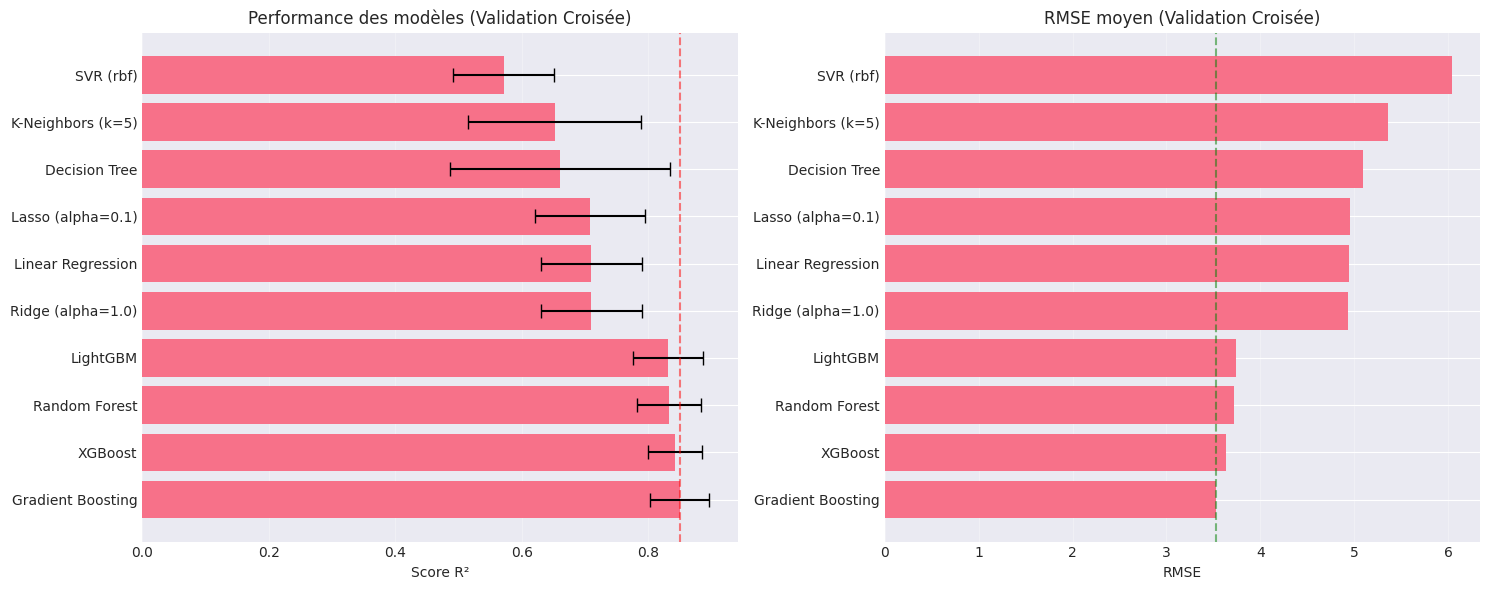


🎯 ÉVALUATION SUR LE TEST SET
Linear Regression         | R² = 0.6839 | RMSE = 4.81 | MAE = 3.21
Ridge (alpha=1.0)         | R² = 0.6829 | RMSE = 4.82 | MAE = 3.21
Lasso (alpha=0.1)         | R² = 0.6595 | RMSE = 5.00 | MAE = 3.21
Decision Tree             | R² = 0.8794 | RMSE = 2.97 | MAE = 2.37
Random Forest             | R² = 0.8895 | RMSE = 2.85 | MAE = 2.02
Gradient Boosting         | R² = 0.9139 | RMSE = 2.51 | MAE = 1.87
K-Neighbors (k=5)         | R² = 0.6055 | RMSE = 5.38 | MAE = 2.89
SVR (rbf)                 | R² = 0.5858 | RMSE = 5.51 | MAE = 3.02
XGBoost                   | R² = 0.8956 | RMSE = 2.77 | MAE = 1.99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 18
[LightGBM] [Info] Start training from score 22.796535
[LightGBM] [Warning] No fur

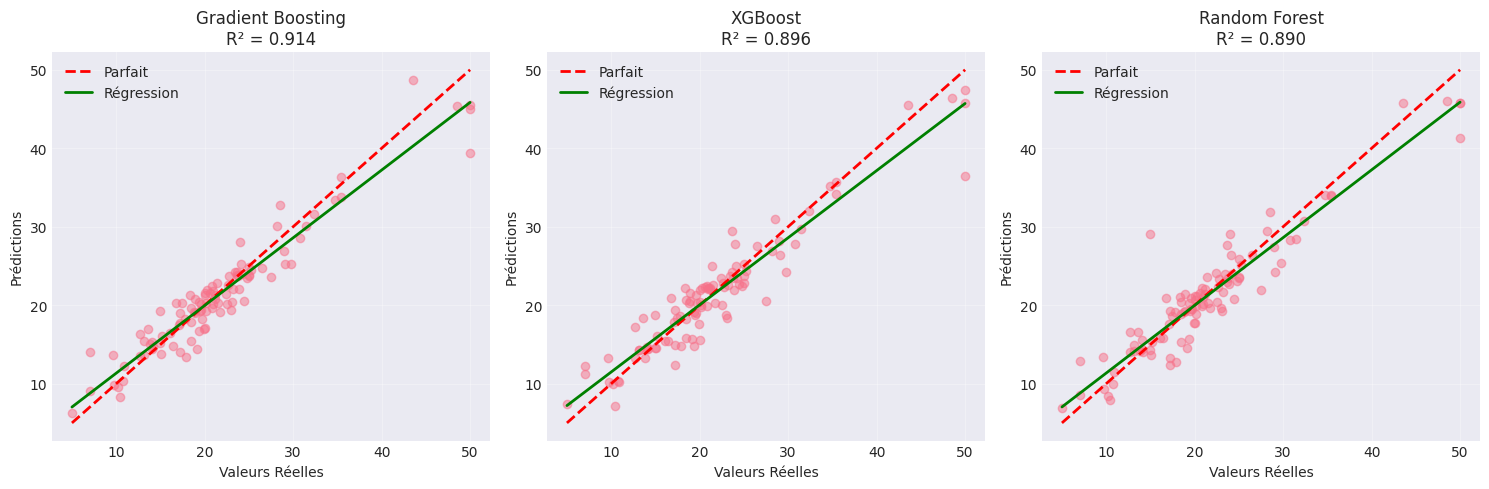


🔍 ANALYSE DES RÉSIDUS


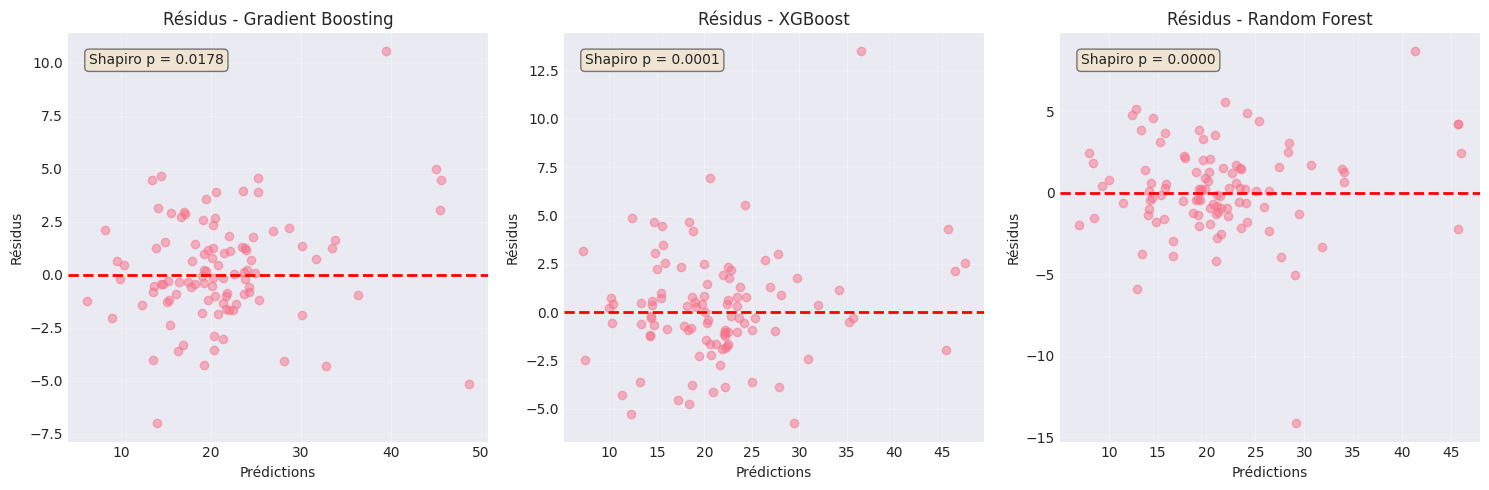

In [26]:
print("BENCHMARK DES MODÈLES")
print("="*60)

# %%
# DÉFINITION DES MODÈLES À TESTER
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0),
    'Lasso (alpha=0.1)': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'K-Neighbors (k=5)': KNeighborsRegressor(n_neighbors=5),
    'SVR (rbf)': SVR(kernel='rbf'),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

# %%
# VALIDATION CROISÉE (5-fold)
print("\n📊 VALIDATION CROISÉE (5-fold) :")
print("-"*60)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    # Scores R²
    r2_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    
    # Scores RMSE (négatif car cross_val_score maximise)
    neg_mse_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                                    scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-neg_mse_scores)
    
    # Scores MAE
    neg_mae_scores = cross_val_score(model, X_train, y_train, cv=cv,
                                    scoring='neg_mean_absolute_error')
    mae_scores = -neg_mae_scores
    
    cv_results[name] = {
        'R2_mean': r2_scores.mean(),
        'R2_std': r2_scores.std(),
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
        'MAE_mean': mae_scores.mean(),
        'MAE_std': mae_scores.std()
    }
    
    print(f"{name:25} | R² = {r2_scores.mean():.4f} (±{r2_scores.std():.4f}) | "
          f"RMSE = {rmse_scores.mean():.2f}")

# %%
# VISUALISATION DES RÉSULTATS CV

# Trier par R²
sorted_results = sorted(cv_results.items(), key=lambda x: x[1]['R2_mean'], reverse=True)
model_names = [name for name, _ in sorted_results]
r2_means = [results['R2_mean'] for _, results in sorted_results]
r2_stds = [results['R2_std'] for _, results in sorted_results]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Graphique 1 : R² scores
bars1 = axes[0].barh(range(len(model_names)), r2_means, xerr=r2_stds, capsize=5)
axes[0].set_yticks(range(len(model_names)))
axes[0].set_yticklabels(model_names)
axes[0].set_xlabel('Score R²')
axes[0].set_title('Performance des modèles (Validation Croisée)')
axes[0].axvline(x=np.max(r2_means), color='red', linestyle='--', alpha=0.5)
axes[0].grid(True, alpha=0.3, axis='x')

# Graphique 2 : RMSE scores
rmse_means = [results['RMSE_mean'] for _, results in sorted_results]
bars2 = axes[1].barh(range(len(model_names)), rmse_means)
axes[1].set_yticks(range(len(model_names)))
axes[1].set_yticklabels(model_names)
axes[1].set_xlabel('RMSE')
axes[1].set_title('RMSE moyen (Validation Croisée)')
axes[1].axvline(x=np.min(rmse_means), color='green', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# %%
# ENTRAÎNEMENT ET ÉVALUATION SUR LE TEST SET
print("\n" + "="*60)
print("🎯 ÉVALUATION SUR LE TEST SET")
print("="*60)

test_results = {}
predictions = {}

for name, model in models.items():
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    # Métriques
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    test_results[name] = {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae
    }
    
    print(f"{name:25} | R² = {r2:.4f} | RMSE = {rmse:.2f} | MAE = {mae:.2f}")

# %%
# COMPARAISON VISUELLE DES PRÉDICTIONS
print("\n" + "="*60)
print("📈 COMPARAISON DES PRÉDICTIONS")
print("="*60)

# Sélectionner les 3 meilleurs modèles
sorted_test_results = sorted(test_results.items(), key=lambda x: x[1]['R2'], reverse=True)
top_3_models = [name for name, _ in sorted_test_results[:3]]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, model_name in enumerate(top_3_models):
    y_pred = predictions[model_name]
    
    axes[idx].scatter(y_test, y_pred, alpha=0.5)
    
    # Ligne parfaite
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Parfait')
    
    # Ligne de régression
    coeffs = np.polyfit(y_test, y_pred, 1)
    line_x = np.array([y_test.min(), y_test.max()])
    line_y = coeffs[0] * line_x + coeffs[1]
    axes[idx].plot(line_x, line_y, 'g-', lw=2, label='Régression')
    
    axes[idx].set_xlabel('Valeurs Réelles')
    axes[idx].set_ylabel('Prédictions')
    axes[idx].set_title(f'{model_name}\nR² = {test_results[model_name]["R2"]:.3f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# ANALYSE DES RÉSIDUS
print("\n" + "="*60)
print("🔍 ANALYSE DES RÉSIDUS")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, model_name in enumerate(top_3_models):
    y_pred = predictions[model_name]
    residuals = y_test - y_pred
    
    axes[idx].scatter(y_pred, residuals, alpha=0.5)
    axes[idx].axhline(y=0, color='red', linestyle='--', lw=2)
    axes[idx].set_xlabel('Prédictions')
    axes[idx].set_ylabel('Résidus')
    axes[idx].set_title(f'Résidus - {model_name}')
    axes[idx].grid(True, alpha=0.3)
    
    # Test de normalité des résidus
    from scipy.stats import shapiro
    stat, p_value = shapiro(residuals[:1000])  # Limité pour Shapiro
    axes[idx].text(0.05, 0.95, f'Shapiro p = {p_value:.4f}', 
                   transform=axes[idx].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### Observations

1. Meilleur modèle : Gradient Boosting obtient le meilleur score R² (0.8498) et le plus faible RMSE (3.53)

2. Robustesse : Les modèles ensemblistes (Random Forest, Gradient Boosting, XGBoost) surclassent nettement les modèles linéaires

3. Stabilité : Gradient Boosting et XGBoost présentent les écarts-types les plus faibles en validation croisée

4. Modèles linéaires : Performance correcte mais inférieure aux méthodes ensemblistes

5. SVR : Performance la plus faible parmi tous les modèles testés

### Conclusion

Le Gradient Boosting est retenu comme modèle optimal pour cette tâche de régression immobilière, offrant le meilleur compromis entre précision (R² élevé) et robustesse (faible variance). Son RMSE de 3.53 signifie que les prédictions s'écartent en moyenne de 3.53 unités (en milliers de dollars) des valeurs réelles.